In [12]:
import ipyparallel as parallel
import pandas as pd
import numpy as np
import random
import timeit, functools
import copy

In [13]:
apple_df = pd.read_csv('data\\apple_2011.csv',names =['date','price','percent_change'],skiprows=1)
apple_df

,date,price,percent_change
0,1/3/2011,329.570,XXXXX
1,1/4/2011,331.290,0.005218922
2,1/5/2011,334.000,0.008180144
3,1/6/2011,333.730,-0.000808383
4,1/7/2011,336.120,0.007161478
5,1/10/2011,342.455,0.018847435
6,1/11/2011,341.640,-0.002379875
7,1/12/2011,344.420,0.00813722
8,1/13/2011,345.680,0.003658324
9,1/14/2011,348.480,0.008099977


Populating the interactive namespace from numpy and matplotlib


C:\Users\Shyam\Anaconda2\envs\snakes\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random', 'copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


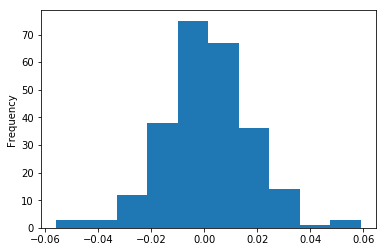

In [14]:
%pylab inline
apple_df.set_value(0,'percent_change','0')
apple_df.percent_change = apple_df.percent_change.astype('float64')
apple_df.percent_change.plot.hist()

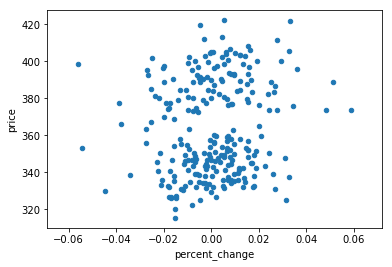

In [155]:
apple_df.plot.scatter('percent_change','price')

In [148]:
#Function for complete calculation

def random_array(apple_df):
    import pandas as pd
    import numpy as np
    import copy
    apple_df.set_value(0,'percent_change','0')
    apple_df.percent_change = apple_df.percent_change.astype('float64')
    last_price = apple_df['price'].loc[apple_df['price'].idxmax()]
    final_df = np.array([])
    count=20
    final_value = 0
    for j in range(0,10000):
        sample_df = pd.DataFrame(apple_df.percent_change.sample(n=count))
        sample_df = sample_df.reset_index(drop=True)
        sample_df['updated_price'] = 0
        sample_df.set_value(0,'updated_price',405)
        sample_df['percent_change']=sample_df['percent_change'] + 1
        for i in range(1,count):
            sample_df.set_value(i,'updated_price',sample_df.updated_price.iloc[[i-1]] * sample_df['percent_change'].loc[sample_df.index[i]])
        final_value = sample_df.get_value(count-1,'updated_price')
        final_df = np.append(final_df,final_value)
    return(final_df)
    #print(final_df)

In [149]:
#Start 4 clients
clients = parallel.Client()
#clients.block = True
print(clients.ids)
dview = clients.direct_view()

[0, 1, 2, 3]


In [151]:
#With clients and load balancer
view = clients.load_balanced_view()
#view.apply_sync(random_array,apple_df)
s2 = timeit.Timer(functools.partial(view.apply,random_array,apple_df))
s2.timeit(number=10000)

15.896673162708794

In [156]:
#Without clients and load balancer
s2 = timeit.Timer(functools.partial(random_array,apple_df))
s2.timeit(number=1)

137.65057324682766

In [153]:
#Final 1% lowest percentile
final_df = random_array(apple_df)
np.percentile(final_df,1)

339.0

(array([   15.,   169.,   853.,  2279.,  2895.,  2344.,  1047.,   323.,
           64.,    11.]),
 array([ 302. ,  323.8,  345.6,  367.4,  389.2,  411. ,  432.8,  454.6,
         476.4,  498.2,  520. ]),
 <a list of 10 Patch objects>)

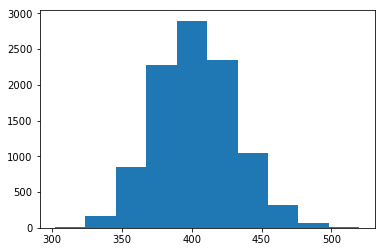

In [154]:
hist(final_df)